## Chronos_Fx-Price Finetuned Multi M


In [ ]:
pip install chronos-forecasting

In [ ]:
import pandas as pd
from chronos import BaseChronosPipeline

pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cuda")


## Finetune Best Param

In [3]:
from __future__ import annotations
import io, time, math, itertools
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Callable, List

import numpy as np
import pandas as pd
import requests, certifi
from sklearn.metrics import mean_absolute_error

import torch
from chronos import BaseChronosPipeline  # chronos-forecasting>=2.0



FINETUNE_FX_COLS = [
    "AUD", "CAD", "CHF", "DKK", "GBP",
    "ISK", "JPY", "NZD", "SEK", "USD", "XDR",
]

NB_PANEL_URL = (
    "https://raw.githubusercontent.com/bredeespelid/"
    "Data_MasterOppgave/refs/heads/main/FineTuneData/NB1980-1999.csv"
)

@dataclass
class FTConfig:
    prediction_length: int = 32
    num_steps: int = 50
    learning_rate: float = 1e-5
    batch_size: int = 2
    logging_steps: int = 10
    max_context: int = 2048
    min_hist_days: int = 40
    m_freq: str = "M"
    verbose: bool = True

FTCFG = FTConfig()


# -----------------------------
# Helpers
# -----------------------------
def download_csv_text(url: str, retries: int = 3, timeout: int = 60) -> str:
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                time.sleep(1.5 * k)
    raise RuntimeError(f"Download failed: {last_err}")


def load_finetune_fx_panel(url: str) -> pd.DataFrame:
    text = download_csv_text(url)
    raw = pd.read_csv(
        io.StringIO(text),
        sep=";",
        decimal=".",
        encoding="utf-8-sig",
    )
    required = ["ds"] + FINETUNE_FX_COLS
    missing = set(required) - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in fine-tune CSV: {missing}")

    df = (
        raw[required]
        .rename(columns={"ds": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], dayfirst=True, errors="coerce"))
        .dropna(subset=["DATE"])
        .sort_values("DATE")
        .set_index("DATE")
    )
    for c in FINETUNE_FX_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(how="all", subset=FINETUNE_FX_COLS)
    return df


def build_base_chronos_pipeline() -> BaseChronosPipeline:
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available.")
    return BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )


def finetune_chronos_on_nb_panel(
    pipeline: BaseChronosPipeline,
    fx_panel: pd.DataFrame,
    ft_params: FTConfig,
) -> BaseChronosPipeline:
    train_inputs: List[Dict] = []
    for col in FINETUNE_FX_COLS:
        series = fx_panel[col].dropna().astype(np.float32).values
        if series.size < ft_params.prediction_length * 2:
            continue
        train_inputs.append(
            {"target": series, "past_covariates": {}, "future_covariates": {}}
        )

    if not train_inputs:
        raise RuntimeError("No valid series for fine-tuning.")

    pipeline = pipeline.fit(
        inputs=train_inputs,
        prediction_length=ft_params.prediction_length,
        num_steps=ft_params.num_steps,
        learning_rate=ft_params.learning_rate,
        batch_size=ft_params.batch_size,
        logging_steps=ft_params.logging_steps,
    )
    return pipeline


def series_daily_and_b(df_d: pd.DataFrame, col: str) -> Tuple[pd.Series, pd.Series]:
    S_d = df_d[col].astype(float)
    S_b = S_d.asfreq("B").ffill()
    return S_b, S_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


def build_model_chronos2_multi_priceonly(
    pipeline: BaseChronosPipeline,
    max_context: int,
) -> Callable[[np.ndarray, int], np.ndarray]:

    def extract_median(pred: pd.DataFrame) -> np.ndarray:
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")
        if "0.5" in df.columns:
            arr = df["0.5"].to_numpy()
        elif "predictions" in df.columns:
            arr = df["predictions"].to_numpy()
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            arr = df["forecast"].to_numpy()
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    arr = df[cand].to_numpy()
                    break
            else:
                raise RuntimeError("Unsupported Chronos schema.")
        return np.asarray(arr, dtype=float)

    def forecast_fn(x: np.ndarray, H: int) -> np.ndarray:
        ctx = np.asarray(x, dtype=float).ravel()[-max_context:]
        ts = pd.date_range("2000-01-01", periods=len(ctx), freq="D")
        df = pd.DataFrame({"item_id": "series_1", "timestamp": ts, "target": ctx})
        with torch.inference_mode():
            pred = pipeline.predict_df(
                df,
                prediction_length=H,
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
            )
        med = extract_median(pred)
        return med[:H]

    return forecast_fn


def walk_forward_monthly_priceonly(
    S_b: pd.Series,
    S_d: pd.Series,
    forecast_fn: Callable[[np.ndarray, int], np.ndarray],
    m_freq: str = "M",
    min_hist_days: int = 40,
    max_context: int = 2048,
    max_horizon: int = 64,
    start_period: Optional[pd.Period] = None,
) -> pd.DataFrame:
    first_m = pd.Period(S_b.index.min(), freq=m_freq)
    last_m  = pd.Period(S_b.index.max(),  freq=m_freq)
    if start_period is not None:
        first_m = max(first_m, start_period)
    months = pd.period_range(first_m, last_m, freq=m_freq)

    rows, dropped = {}, {}

    for m in months:
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(m)] = "no_cut"
            continue

        hist_d = S_d.loc[:cut]
        if hist_d.size < min_hist_days:
            dropped[str(m)] = "short_hist"
            continue

        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            dropped[str(m)] = "no_bdays"
            continue
        y_true = float(S_b.loc[idx_m_b].mean())

        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > max_horizon:
            dropped[str(m)] = "bad_H"
            continue

        context = min(max_context, len(hist_d))
        x = hist_d.values[-context:]
        pf = forecast_fn(x, H)

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf[:H], index=f_idx)

        pred_b = pred_daily.reindex(idx_m_b, method=None)
        if pred_b.isna().all():
            dropped[str(m)] = "no_overlap"
            continue
        y_pred = float(pred_b.dropna().mean())

        rows[str(m)] = {"month": m, "y_true": y_true, "y_pred": y_pred}

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("month").sort_index()
    return df


def rmse_mae(df_eval: pd.DataFrame) -> Tuple[float, float]:
    core = df_eval.dropna()
    if core.empty:
        return np.nan, np.nan
    err = core["y_true"] - core["y_pred"]
    rmse = float(np.sqrt(np.mean(err**2)))
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"]))
    return rmse, mae


# -----------------------------
# 1) Load NB panel and split train/val
# -----------------------------
fx_panel_full = load_finetune_fx_panel(NB_PANEL_URL)

val_start = pd.Timestamp("1996-01-01")
train_panel = fx_panel_full.loc[:val_start - pd.Timedelta(days=1)]
val_panel   = fx_panel_full.loc[val_start:]

if FTCFG.verbose:
    print(f"NB full:  {fx_panel_full.index.min().date()} → {fx_panel_full.index.max().date()} | n={len(fx_panel_full)}")
    print(f"Train:    {train_panel.index.min().date()} → {train_panel.index.max().date()} | n={len(train_panel)}")
    print(f"Validate: {val_panel.index.min().date()} → {val_panel.index.max().date()} | n={len(val_panel)}")

val_start_period = pd.Period(val_panel.index.min(), freq=FTCFG.m_freq)


grid = {
    "learning_rate": [5e-6, 1e-5, 2e-5],
    "num_steps": [20, 50, 100],
    "batch_size": [2, 4],
    "prediction_length": [32],
}

param_list = list(itertools.product(
    grid["learning_rate"],
    grid["num_steps"],
    grid["batch_size"],
    grid["prediction_length"],
))

results = []

# -----------------------------
# 3) Tuning-loop: finetune på train, valider på val (walk-forward)
# -----------------------------
for lr, steps, bs, pl in param_list:
    ft_params = FTConfig(
        prediction_length=pl,
        num_steps=steps,
        learning_rate=lr,
        batch_size=bs,
        logging_steps=FTCFG.logging_steps,
        max_context=FTCFG.max_context,
        min_hist_days=FTCFG.min_hist_days,
        m_freq=FTCFG.m_freq,
        verbose=False,
    )

    base_pipe = build_base_chronos_pipeline()
    ft_pipe = finetune_chronos_on_nb_panel(base_pipe, train_panel, ft_params)
    forecast_fn = build_model_chronos2_multi_priceonly(ft_pipe, max_context=ft_params.max_context)

    series_rmses = []
    series_maes  = []

    val_daily = val_panel.asfreq("D").ffill()

    for col in FINETUNE_FX_COLS:
        if col not in val_daily.columns:
            continue
        S_b, S_d = series_daily_and_b(val_daily, col)

        df_eval = walk_forward_monthly_priceonly(
            S_b=S_b,
            S_d=S_d,
            forecast_fn=forecast_fn,
            m_freq=ft_params.m_freq,
            min_hist_days=ft_params.min_hist_days,
            max_context=ft_params.max_context,
            max_horizon=64,
            start_period=val_start_period,
        )
        r, m_ = rmse_mae(df_eval)
        if np.isfinite(r):
            series_rmses.append(r)
            series_maes.append(m_)

    avg_rmse = float(np.mean(series_rmses)) if series_rmses else np.nan
    avg_mae  = float(np.mean(series_maes)) if series_maes else np.nan

    results.append({
        "learning_rate": lr,
        "num_steps": steps,
        "batch_size": bs,
        "prediction_length": pl,
        "val_avg_rmse": avg_rmse,
        "val_avg_mae": avg_mae,
    })

    print(f"lr={lr:.0e}, steps={steps}, bs={bs} -> val_RMSE={avg_rmse:.4f}, val_MAE={avg_mae:.4f}")


res_df = pd.DataFrame(results).sort_values("val_avg_rmse")
best = res_df.iloc[0].to_dict()

print("\nBest params (val):")
print(best)

BEST_FT_PARAMS = FTConfig(
    prediction_length=int(best["prediction_length"]),
    num_steps=int(best["num_steps"]),
    learning_rate=float(best["learning_rate"]),
    batch_size=int(best["batch_size"]),
    logging_steps=FTCFG.logging_steps,
    max_context=FTCFG.max_context,
    min_hist_days=FTCFG.min_hist_days,
    m_freq=FTCFG.m_freq,
    verbose=True,
)


`torch_dtype` is deprecated! Use `dtype` instead!


NB full:  1980-12-10 → 1999-12-31 | n=4930
Train:    1980-12-10 → 1995-12-29 | n=3919
Validate: 1996-01-02 → 1999-12-31 | n=1011


`torch_dtype` is deprecated! Use `dtype` instead!
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.652300
20,1.315200


lr=5e-06, steps=20, bs=2 -> val_RMSE=1.0737, val_MAE=0.7723


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.227900
20,2.371600


lr=5e-06, steps=20, bs=4 -> val_RMSE=1.0551, val_MAE=0.7604


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.651900
20,1.331600
30,1.810900
40,2.944600
50,1.152200


lr=5e-06, steps=50, bs=2 -> val_RMSE=1.0844, val_MAE=0.7558


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.228500
20,2.418000
30,1.815100
40,2.570000
50,2.649400


lr=5e-06, steps=50, bs=4 -> val_RMSE=1.0798, val_MAE=0.7669


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.651800
20,1.338400
30,1.835900
40,3.005300
50,1.166400
60,2.127100
70,2.717200
80,1.886600
90,2.821900
100,1.562700


lr=5e-06, steps=100, bs=2 -> val_RMSE=1.0646, val_MAE=0.7583


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.228900
20,2.432800
30,1.829200
40,2.584300
50,2.613600
60,1.641400
70,2.308600
80,1.844400
90,2.569100
100,1.969100


lr=5e-06, steps=100, bs=4 -> val_RMSE=1.0732, val_MAE=0.7753


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.728700
20,1.445700


lr=1e-05, steps=20, bs=2 -> val_RMSE=1.0776, val_MAE=0.7890


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.233800
20,2.618400


lr=1e-05, steps=20, bs=4 -> val_RMSE=1.0787, val_MAE=0.7787


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.729300
20,1.456500
30,1.922500
40,3.139000
50,1.247100


lr=1e-05, steps=50, bs=2 -> val_RMSE=1.1040, val_MAE=0.7730


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.240200
20,2.670700
30,1.861500
40,2.614400
50,2.659500


lr=1e-05, steps=50, bs=4 -> val_RMSE=1.0837, val_MAE=0.7702


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.729900
20,1.471000
30,1.975300
40,3.220800
50,1.218800
60,2.269500
70,2.641600
80,1.904100
90,2.883200
100,1.711000


lr=1e-05, steps=100, bs=2 -> val_RMSE=1.0675, val_MAE=0.7749


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.243400
20,2.687700
30,1.880000
40,2.660200
50,2.638200
60,1.649700
70,2.351600
80,1.877400
90,2.636300
100,2.047200


lr=1e-05, steps=100, bs=4 -> val_RMSE=1.0692, val_MAE=0.7984


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.892100
20,1.961500


lr=2e-05, steps=20, bs=2 -> val_RMSE=1.1139, val_MAE=0.8323


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.287000
20,2.941800


lr=2e-05, steps=20, bs=4 -> val_RMSE=1.1275, val_MAE=0.8241


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.898900
20,1.880000
30,2.611700
40,3.172500
50,1.211200


lr=2e-05, steps=50, bs=2 -> val_RMSE=1.0908, val_MAE=0.7881


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.316200
20,3.023500
30,1.904900
40,2.765400
50,2.628400


lr=2e-05, steps=50, bs=4 -> val_RMSE=1.0766, val_MAE=0.7833


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.900000
20,1.885100
30,2.458400
40,3.265200
50,1.255100
60,2.590900
70,2.696300
80,2.155100
90,2.646000
100,1.747600


lr=2e-05, steps=100, bs=2 -> val_RMSE=1.0899, val_MAE=0.7959


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.326700
20,3.069300
30,1.894400
40,2.801100
50,2.587400
60,1.771300
70,2.656800
80,1.975600
90,2.928300
100,2.249700


lr=2e-05, steps=100, bs=4 -> val_RMSE=1.1065, val_MAE=0.8578

Best params (val):
{'learning_rate': 5e-06, 'num_steps': 20.0, 'batch_size': 4.0, 'prediction_length': 32.0, 'val_avg_rmse': 1.0551303039975972, 'val_avg_mae': 0.7603691171620345}


## Chronos LOFO M

Selected covariates: ['VIX', 'StoxEurope', 'SP500', 'OSEBX', 'OBX_Energy', 'd_pi', 'dI_t']
Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416

Fine-tune panel: 1980-12-10 → 1999-12-31 | n=4930

[Fine-tuning Chronos-2 on NB FX panel 1980–1999]
  Series used: 11
  prediction_length=32, num_steps=20, lr=5e-06, batch_size=4


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.861500
20,2.373200



Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

=== Model performance (monthly mean, EUR/NOK – finetuned, past covs) ===
Observations: 308
RMSE (level): 0.145380
MAE  (level): 0.100500
Directional accuracy: 208/307 (67.8%)

=== Diebold–Mariano vs Random Walk (finetuned, past covs) ===
Loss: MSE | horizon h=1
DM-statistic: -2.0849
p-value     : 0.0371


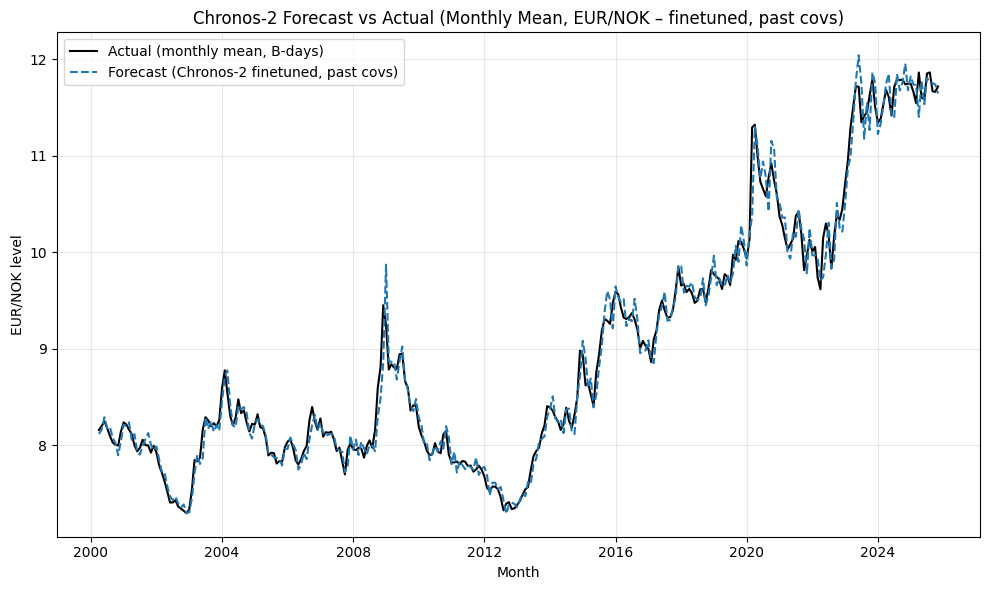

Saved: Chronos2M_daily_importantcov_FT.png
Saved: Chronos2M_daily_importantcov_FT.pdf


In [6]:

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Callable, List

import numpy as np
import pandas as pd
import requests, certifi
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import torch
from chronos import BaseChronosPipeline  # chronos-forecasting>=2.0


# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    # EUR/NOK + covariates dataset
    url_main: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    # Fine-tuning panel (Norges Bank 1980–1999)
    url_finetune: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/FineTuneData/NB1980-1999.csv"
    )

    m_freq: str = "M"
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon: int = 64
    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "Chronos2M_daily_importantcov_FT.png"
    fig_pdf: str = "Chronos2M_daily_importantcov_FT.pdf"

CFG = Config()

TARGET_SERIES = "EUR_NOK"

# Past covariates (delta_p > 0)
EXOG_COLS = ["VIX", "StoxEurope", "SP500", "OSEBX", "OBX_Energy"]
MACRO_COLS = ["d_pi", "dI_t"]
ALL_COV_COLS = EXOG_COLS + MACRO_COLS

# FX columns for fine-tuning
FINETUNE_FX_COLS = [
    "AUD", "CAD", "CHF", "DKK", "GBP",
    "ISK", "JPY", "NZD", "SEK", "USD", "XDR",
]


# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")


# -----------------------------
# Data loading (EUR/NOK + covs)
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.DataFrame]:
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date", TARGET_SERIES} | set(ALL_COV_COLS)
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET_SERIES])
        .sort_values("DATE")
        .set_index("DATE")
    )

    num_cols = list(required_cols - {"Date"})
    for col in num_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=[TARGET_SERIES])

    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


def make_pastcov_context(hist_wide: pd.DataFrame) -> pd.DataFrame:
    ctx = pd.DataFrame({
        "timestamp": hist_wide.index,
        "item_id": TARGET_SERIES,
        "target": hist_wide[TARGET_SERIES].astype(float).values,
    })
    for c in ALL_COV_COLS:
        ctx[c] = hist_wide[c].astype(float).values
    return ctx.sort_values("timestamp")


# -----------------------------
# Load fine-tuning FX panel (1980–1999)
# -----------------------------
def load_finetune_fx_panel(url: str) -> pd.DataFrame:
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(
        io.StringIO(text),
        sep=";",
        decimal=".",
        encoding="utf-8-sig",
    )

    required = ["ds"] + FINETUNE_FX_COLS
    missing = set(required) - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in fine-tune CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[required]
        .rename(columns={"ds": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], dayfirst=True, errors="coerce"))
        .dropna(subset=["DATE"])
        .sort_values("DATE")
        .set_index("DATE")
    )

    for col in FINETUNE_FX_COLS:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    df = df.dropna(how="all", subset=FINETUNE_FX_COLS)
    return df


# -----------------------------
# Chronos-2 pipeline + fine-tuning
# -----------------------------
def build_base_chronos_pipeline() -> BaseChronosPipeline:
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Install CUDA PyTorch + drivers.")
    return BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )


def finetune_chronos_on_nb_panel(
    pipeline: BaseChronosPipeline,
    fx_panel: pd.DataFrame,
    ft_params,
) -> BaseChronosPipeline:
    train_inputs: List[Dict] = []

    for col in FINETUNE_FX_COLS:
        series = fx_panel[col].dropna().astype(np.float32).values
        if series.size < ft_params.prediction_length * 2:
            continue
        train_inputs.append(
            {"target": series, "past_covariates": {}, "future_covariates": {}}
        )

    if CFG.verbose:
        print("\n[Fine-tuning Chronos-2 on NB FX panel 1980–1999]")
        print(f"  Series used: {len(train_inputs)}")
        print(
            f"  prediction_length={ft_params.prediction_length}, "
            f"num_steps={ft_params.num_steps}, lr={ft_params.learning_rate}, "
            f"batch_size={ft_params.batch_size}"
        )

    return pipeline.fit(
        inputs=train_inputs,
        prediction_length=ft_params.prediction_length,
        num_steps=ft_params.num_steps,
        learning_rate=ft_params.learning_rate,
        batch_size=ft_params.batch_size,
        logging_steps=ft_params.logging_steps,
    )


# -----------------------------
# Forecast function: past covariates, NO cross-learning
# -----------------------------
def build_model_chronos2_pastcov_finetuned(
    pipeline: BaseChronosPipeline,
    max_context: int,
) -> Callable[[pd.DataFrame, int], pd.DataFrame]:

    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")

        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Unsupported schema: {list(df.columns)}")

        return df[["item_id", "timestamp", "y_pred"]].copy()

    def _forecast(context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        if len(context_df) > max_context:
            context_df = context_df.iloc[-max_context:].copy()

        with torch.inference_mode():
            pred = pipeline.predict_df(
                context_df,
                prediction_length=H,
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                predict_batches_jointly=False,  # NO cross-learning
            )
        return _extract_median(pred)

    return _forecast


# -----------------------------
# Walk-forward (monthly)
# -----------------------------
def walk_forward_chronos2_monthly_pastcov(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
) -> pd.DataFrame:

    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m  = pd.Period(S_b.index.max(),  freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    rows: Dict = {}
    dropped: Dict[str, str] = {}

    for m in months:
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(m)] = "no_cut_in_prev_month"
            continue

        hist_wide = DF_d.loc[:cut]
        if hist_wide.shape[0] < CFG.min_hist_days:
            dropped[str(m)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            dropped[str(m)] = "no_bdays_in_month"
            continue
        y_true = float(S_b.loc[idx_m_b].mean())

        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(m)] = f"horizon_invalid(H={H})"
            continue

        context_df = make_pastcov_context(hist_wide)
        df_pred = forecast_fn(context_df, H)
        if df_pred.empty:
            dropped[str(m)] = "no_predictions"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")

        df_fx = df_pred[df_pred["item_id"] == TARGET_SERIES].copy().sort_values("timestamp")

        pred_daily = pd.Series(index=f_idx, dtype=float)
        tmp = df_fx.set_index("timestamp")["y_pred"]
        common_idx = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common_idx] = tmp.loc[common_idx]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_m_b, method=None)
        if pred_b.isna().all():
            dropped[str(m)] = "no_overlap_pred_B_days"
            continue
        y_pred = float(pred_b.dropna().mean())

        rows[str(m)] = {"month": m, "cut": cut, "y_true": y_true, "y_pred": y_pred}

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("month").sort_index()

    if CFG.verbose and dropped:
        miss = [str(m) for m in months if m not in df.index]
        if miss:
            print("\nDropped months and reasons:")
            for mm in miss:
                print(f"  {mm}: {dropped.get(mm, 'unknown')}")
    return df


# -----------------------------
# Evaluation / DM / Plot
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (monthly mean, EUR/NOK – finetuned, past covs) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core


def _normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))


def dm_test(y_true, y_model, y_rw, h: int = 1, loss: str = "mse"):
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val


def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1):
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (finetuned, past covs) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")


def plot_monthly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (monthly mean, B-days)")
    plt.plot(x, eval_df["y_pred"], color="tab:blue", linestyle="--",
             label="Forecast (Chronos-2 finetuned, past covs)")

    plt.title("Chronos-2 Forecast vs Actual (Monthly Mean, EUR/NOK – finetuned, past covs)")
    plt.xlabel("Month")
    plt.ylabel("EUR/NOK level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")


# -----------------------------
# Main run
# -----------------------------
def main():
    # Load EUR/NOK + covs
    S_b, DF_d = load_series(CFG.url_main)

    if CFG.verbose:
        print(f"Selected covariates: {ALL_COV_COLS}")
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")

    # Load fine-tune panel
    fx_panel = load_finetune_fx_panel(CFG.url_finetune)
    ft_start, ft_end = fx_panel.index.min(), fx_panel.index.max()

    if CFG.verbose:
        print(f"\nFine-tune panel: {ft_start.date()} → {ft_end.date()} | n={len(fx_panel)}")

    # Base -> fine-tuned pipeline (price-only)
    base_pipe = build_base_chronos_pipeline()
    ft_pipe = finetune_chronos_on_nb_panel(base_pipe, fx_panel, BEST_FT_PARAMS)

    # Past-cov forecast function using fine-tuned pipeline
    forecast_fn = build_model_chronos2_pastcov_finetuned(
        pipeline=ft_pipe,
        max_context=CFG.max_context,
    )

    # Walk-forward monthly
    df_eval = walk_forward_chronos2_monthly_pastcov(S_b, DF_d, forecast_fn)

    eval_df = evaluate(df_eval)
    dm_against_random_walk(eval_df, loss="mse", h=1)
    plot_monthly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)


if __name__ == "__main__":
    main()


## Chronos 2 LOFO Q

Important covariates: ['VIX', 'SP500', 'Q']
Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416

Fine-tune panel: 1980-12-10 → 1999-12-31 | n=4930

[Fine-tuning Chronos-2 on NB FX panel 1980–1999]
  Series used: 11
  prediction_length=32, num_steps=20, lr=5e-06, batch_size=4


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.861500
20,2.373200



Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

=== Model performance (quarterly mean, EUR/NOK – finetuned, important covs) ===
Observations: 103
RMSE (level): 0.197115
MAE  (level): 0.145156
Directional accuracy: 77/102 (75.5%)

=== Diebold–Mariano vs Random Walk (finetuned, important covs, quarterly) ===
Loss: MSE | horizon h=1
DM-statistic: -2.2740
p-value     : 0.0230


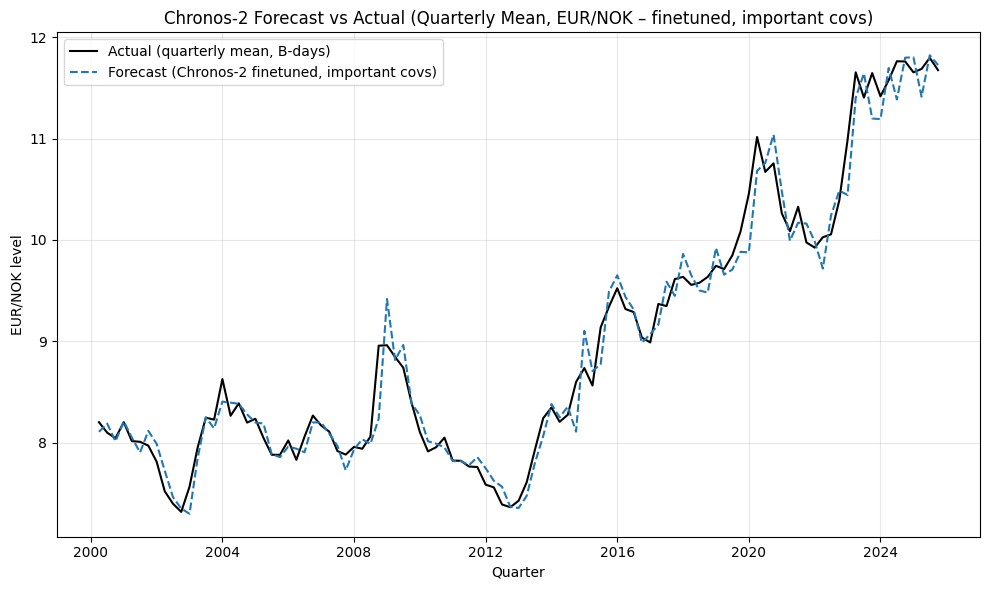

Saved: Chronos2Q_daily_finalcov_FT.png
Saved: Chronos2Q_daily_finalcov_FT.pdf


In [7]:
# CELL — Finetune på NB 1980–1999, deretter EUR/NOK quarterly past-cov (VIX, SP500, Q)

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Callable, List

import numpy as np
import pandas as pd
import requests, certifi
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import torch
from chronos import BaseChronosPipeline  # chronos-forecasting>=2.0


# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    # Main dataset (EUR/NOK + covariates)
    url_main: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    # Fine-tuning panel (NB FX 1980–1999)
    url_finetune: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/FineTuneData/NB1980-1999.csv"
    )

    q_freq: str = "Q-DEC"
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon: int = 128
    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "Chronos2Q_daily_finalcov_FT.png"
    fig_pdf: str = "Chronos2Q_daily_finalcov_FT.pdf"

CFG = Config()

TARGET_SERIES = "EUR_NOK"
IMPORTANT_COV_COLS = ["VIX", "SP500", "Q"]

FINETUNE_FX_COLS = [
    "AUD", "CAD", "CHF", "DKK", "GBP",
    "ISK", "JPY", "NZD", "SEK", "USD", "XDR",
]


# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")


# -----------------------------
# Data loading (EUR/NOK + covs)
# -----------------------------
def load_series(url: str, cov_cols: List[str]) -> Tuple[pd.Series, pd.DataFrame]:
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date", TARGET_SERIES} | set(cov_cols)
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET_SERIES])
        .sort_values("DATE")
        .set_index("DATE")
    )

    num_cols = list(required_cols - {"Date"})
    for col in num_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=[TARGET_SERIES])

    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


def make_pastcov_context(hist_wide: pd.DataFrame, cov_cols: List[str]) -> pd.DataFrame:
    ctx = pd.DataFrame({
        "timestamp": hist_wide.index,
        "item_id": TARGET_SERIES,
        "target": hist_wide[TARGET_SERIES].astype(float).values,
    })
    for c in cov_cols:
        ctx[c] = hist_wide[c].astype(float).values
    return ctx.sort_values("timestamp")


# -----------------------------
# Fine-tuning panel loader
# -----------------------------
def load_finetune_fx_panel(url: str) -> pd.DataFrame:
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text), sep=";", decimal=".", encoding="utf-8-sig")

    required = ["ds"] + FINETUNE_FX_COLS
    missing = set(required) - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in fine-tune CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[required]
        .rename(columns={"ds": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], dayfirst=True, errors="coerce"))
        .dropna(subset=["DATE"])
        .sort_values("DATE")
        .set_index("DATE")
    )

    for col in FINETUNE_FX_COLS:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(how="all", subset=FINETUNE_FX_COLS)
    return df


# -----------------------------
# Chronos-2 base + fine-tuning
# -----------------------------
def build_base_chronos_pipeline() -> BaseChronosPipeline:
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Install CUDA PyTorch + drivers.")
    return BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )


def finetune_chronos_on_nb_panel(
    pipeline: BaseChronosPipeline,
    fx_panel: pd.DataFrame,
    ft_params,
) -> BaseChronosPipeline:
    train_inputs: List[Dict] = []

    for col in FINETUNE_FX_COLS:
        series = fx_panel[col].dropna().astype(np.float32).values
        if series.size < ft_params.prediction_length * 2:
            continue
        train_inputs.append(
            {"target": series, "past_covariates": {}, "future_covariates": {}}
        )

    if not train_inputs:
        raise RuntimeError("No valid series found for fine-tuning.")

    if CFG.verbose:
        print("\n[Fine-tuning Chronos-2 on NB FX panel 1980–1999]")
        print(f"  Series used: {len(train_inputs)}")
        print(
            f"  prediction_length={ft_params.prediction_length}, "
            f"num_steps={ft_params.num_steps}, lr={ft_params.learning_rate}, "
            f"batch_size={ft_params.batch_size}"
        )

    return pipeline.fit(
        inputs=train_inputs,
        prediction_length=ft_params.prediction_length,
        num_steps=ft_params.num_steps,
        learning_rate=ft_params.learning_rate,
        batch_size=ft_params.batch_size,
        logging_steps=ft_params.logging_steps,
    )


# -----------------------------
# Forecast function: past covs, NO cross-learning
# -----------------------------
def build_model_chronos2_pastcov_finetuned(
    pipeline: BaseChronosPipeline,
    max_context: int,
) -> Callable[[pd.DataFrame, int], pd.DataFrame]:

    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")

        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Unsupported schema: {list(df.columns)}")

        return df[["item_id", "timestamp", "y_pred"]].copy()

    def _forecast(context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        if len(context_df) > max_context:
            context_df = context_df.iloc[-max_context:].copy()

        with torch.inference_mode():
            pred = pipeline.predict_df(
                context_df,
                prediction_length=H,
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                predict_batches_jointly=False,  # NO cross-learning
            )
        return _extract_median(pred)

    return _forecast


# -----------------------------
# Quarterly walk-forward
# -----------------------------
def walk_forward_chronos2_quarterly_pastcov(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> pd.DataFrame:

    first_q = pd.Period(S_b.index.min(), freq=CFG.q_freq)
    last_q  = pd.Period(S_b.index.max(),  freq=CFG.q_freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.q_freq)

    rows: Dict = {}
    dropped: Dict[str, str] = {}

    for q in quarters:
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(q)] = "no_cut_in_prev_quarter"
            continue

        hist_wide = DF_d.loc[:cut]
        if hist_wide.shape[0] < CFG.min_hist_days:
            dropped[str(q)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            dropped[str(q)] = "no_bdays_in_quarter"
            continue
        y_true = float(S_b.loc[idx_q_b].mean())

        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(q)] = f"horizon_invalid(H={H})"
            continue

        context_df = make_pastcov_context(hist_wide, cov_cols)
        df_pred = forecast_fn(context_df, H)
        if df_pred.empty:
            dropped[str(q)] = "no_predictions"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        df_fx = df_pred[df_pred["item_id"] == TARGET_SERIES].copy().sort_values("timestamp")

        pred_daily = pd.Series(index=f_idx, dtype=float)
        tmp = df_fx.set_index("timestamp")["y_pred"]
        common_idx = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common_idx] = tmp.loc[common_idx]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            dropped[str(q)] = "no_overlap_pred_B_days"
            continue
        y_pred = float(pred_b.dropna().mean())

        rows[str(q)] = {"quarter": q, "cut": cut, "y_true": y_true, "y_pred": y_pred}

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("quarter").sort_index()

    if CFG.verbose and dropped:
        miss = [str(q) for q in quarters if q not in df.index]
        if miss:
            print("\nDropped quarters and reasons:")
            for qq in miss:
                print(f"  {qq}: {dropped.get(qq, 'unknown')}")
    return df


# -----------------------------
# Evaluation / DM / Plot
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (quarterly mean, EUR/NOK – finetuned, important covs) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core


def _normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))


def dm_test(y_true, y_model, y_rw, h: int = 1, loss: str = "mse"):
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val


def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1):
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (finetuned, important covs, quarterly) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")


def plot_quarterly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (quarterly mean, B-days)")
    plt.plot(x, eval_df["y_pred"], color="tab:blue", linestyle="--",
             label="Forecast (Chronos-2 finetuned, important covs)")

    plt.title("Chronos-2 Forecast vs Actual (Quarterly Mean, EUR/NOK – finetuned, important covs)")
    plt.xlabel("Quarter")
    plt.ylabel("EUR/NOK level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")


# -----------------------------
# Main
# -----------------------------
def main():
    # Load EUR/NOK + important covs
    S_b, DF_d = load_series(CFG.url_main, IMPORTANT_COV_COLS)

    if CFG.verbose:
        print(f"Important covariates: {IMPORTANT_COV_COLS}")
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")

    # Load fine-tune panel
    fx_panel = load_finetune_fx_panel(CFG.url_finetune)
    ft_start, ft_end = fx_panel.index.min(), fx_panel.index.max()

    if CFG.verbose:
        print(f"\nFine-tune panel: {ft_start.date()} → {ft_end.date()} | n={len(fx_panel)}")

    # Base -> fine-tuned pipeline
    base_pipe = build_base_chronos_pipeline()
    ft_pipe = finetune_chronos_on_nb_panel(base_pipe, fx_panel, BEST_FT_PARAMS)

    # Build finetuned past-cov forecast fn
    forecast_fn = build_model_chronos2_pastcov_finetuned(
        pipeline=ft_pipe,
        max_context=CFG.max_context,
    )

    # Quarterly walk-forward
    df_eval = walk_forward_chronos2_quarterly_pastcov(
        S_b, DF_d, forecast_fn, IMPORTANT_COV_COLS
    )
    eval_df = evaluate(df_eval)
    dm_against_random_walk(eval_df, loss="mse", h=1)
    plot_quarterly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)


if __name__ == "__main__":
    main()
